# Applicazione di controllo distribuito

Innanzitutto bisogna chiedersi perché è necessario parlare di controllo della rete e delle topologie. È necessario parlare
di controllo ottimo della rete perché è la procedura che mi permette di garantire un'operazione corretta ed affidabile
della rete. I problemi di stabilità della rete e la necessità di controllo della rete, nasce dalla natura del mezzo fisico
con cui interconnetto i vari device e dalla gestione dell'accesso al mezzo fisico. Il controllo della rete può essere
fatto in più modi attraverso:
* gestione dei metodi di accesso del canale
* gestione dei traffici che generano un'evoluzione dello stato del sistema

La gestione del controllo della rete attraverso i metodi di accesso al canale è una macro categoria di cui non mi occupo.
Per quanto riguarda il controllo della rete mi occupo del problema a livello E2E nell'ottica di controllo della
congestione e controllo di flusso (primariamente attraverso TCP o metodi affini, si veda la discussione finale).

Espongo l'analisi dei dati e le conclusioni ottenute con le simulazioni.

## Ipotesi e statement del problema
Ipotizzo che la trasmissione dei dati soprattutto nel piano di controllo della mia rete segua una distribuzione heavy-
tailed e che al limite converga ad una distribuzione stabile.

L'ipotesi è duplice:
* Il mio sistema genera dati nel piano di controllo con una distribuzione heavy-tailed
* Il processo che genera dati se osservato per un tempo sufficientemente lungo converge ad una distribuzione stabile

Il problema del primo punto è che fare un fit per una distribuzione heavy-tailed è estremamente complicato e i dettagli
matematici sono particolarmente tecnici. Da un punto di vista prettamente numerico, il test $ \chi^2 $ impone di conoscere la
distribuzione sottostante così che possa verificare che le "discrepanze" osservate siano sotto un certo valore. Questa
distribuzione di probabilità sottostante non ce l'ho, e non posso andare "a tentoni" provando tutte le varie distribuzioni
fino a che non trovo quella con uno score minimo. Non posso neanche fare un fit con la log-verosimiglianza cercando con un
MLE di trovare i vari parametri che compongono le distribuzioni, poiché i dati finiscono in regioni inammissibili dei
metodi di ottimizzazione e quindi i valori calcolati sono spesso inaffidabili o con bound di incertezza così elevati che
rendono inutili le stime prodotte.

Dunque per dimostrare il primo punto posso solo osservare che i dati di lunghezza dei pacchetti sulle reti dati (eg Internet)
sono sempre stati classificati come distribuiti secondo pdf heavy-tailed. Il metodo usato solitamente è quello di fare
una mean-excess analysis e vedere com'è fatta la distribuzione dei valori eccezionali. Un secondo metodo empirico, che uso
io in virtù del fatto che il processo sottostante è già stato classificato come heavy-tailed, è quello di andare a cercare conferma della mia
ipotesi guardando la media mobile a corto termine e poi allungando la lunghezza del filtro moving average. Se ottengo un segnale con media
 tempovariante e con un running average che mostra un trend, questo duplice indizio è una condizione necessaria all'essere heavy tailed.

## Statement del problema

Ipotizzo che una rete di sensori in ambito mobile IoT abbia bisogno di una applicazione di rete per il controllo ottimo:
* del traffico
* della topologia
* delle congestioni
* degli sprechi in termini di banda/energia/slot-temporali

Il problema principale, deriva dal fatto che il mezzo trasmissivo che sto usando è wireless ed usando un modello a livello
fisico scopro che ci sono interferenze in ambienti in cui uso radio-propagazione. Solitamente questi problemi vengono
chiamati come il problema del terminale nascosto e terminale scoperto. La soluzione proposta per questi due problemi
"classici" è quella di usare un controllo centralizzato oppure l'uso di pacchetti RTS/CTS. Ognuno di questi metodi ha i
suoi pregi e difetti. Mi concentro sul metodo del controllo *centralizzato* poiché è quello meno investigato di tutti in
ambiente sensori mobile IoT.

### Esempio di non stazionierità del segnale traffico medio

Esaminiamo il seguente dataset raccolto da un insieme di dispositivi con un'applicazione di controllo simile a quella usata nelle
simulazioni del network forming che mostro a seguire. Dai risultati esposti con questo dataset ed il dataset delle simulazioni della tesi
vediamo la conferma di ciò che viene riportato in {cite:p}`Hernandez-CamposMSS02`.
Nell'articolo viene dimostrato come traffici di tipo HTTP o simili, siano distribuiti secondo pmf con heavy-tails. Nell'
articolo menzionato viene data una modellazione dettagliata di quello che è la distribuzione del traffico. **Non** ripeto
l'analisi fatta da loro, in quell'articolo vi è un'osservazione della ecdf e tramite osservazione affermano che il traffico segue
le loro previsioni. Nell'appendice dell'articolo citato, viene data una dimostrazione delle proprietà delle pmf heavy-tailed
e, con una stima, cercano di ottenere l'indice di coda che caratterizza il traffico.

La mia analisi è molto più semplice in questo documento, mi limito a osservare che per il teorma limite centrale della
probabilità io so che: <br>
$\displaystyle P[X_1+X_2+X_3...] \sim N(\mu, \sigma) $ dove $ \mu = \frac{1}{N}(\sum_{i=1}^N X_i) $ <br> ciò che questo dice
è che la somma di N variabili aleatorie convergerà ad una gaussiana con $\mu$ la media campionaria. Questo è vero in una
moltitudine di casi, tra l'altro, la media campionaria è un'ottimo stimatore dela valore medio di una moltitudine di altre
distribuzioni di probabilità. 

    Perché concentrarsi tanto sulle distribuzioni heavy-tailed? 
    
Perché il teorma limite della
probabilità **non** vale nel caso delle distribuzioni fat-tailed. Per convincersene basta osservare che per le funzioni
non regolarmente variabili la "probabilità estrema", e cioè la probabilità che si avverino eventi "estremi", è molto più
probabile che l'evento normale. Questo si può vedere osservando che una distribuzione fat-tailed se ne definiamo la
*survival function* $ F $ di una v.a. $ X $ tale che $ \overline{F}(X) = 1-F(X)=Prob[X>x] $ allora indico con la seguente
scrittura $ \overline{F}(X) \sim x^{-\alpha}, x \to \infty $ per indicare che
$\lim_{x\to \infty} \frac{\overline{F}(X)}{x^{-\alpha}} \to 1 $. Qui $\alpha$ è il tail index, cioè la velocità con cui la
probabilità tende a un valore maggiore di $ x $ con $ x\to \infty $. Nelle distribuzioni per cui vale il teorma limite
centrale questo tasso $ \alpha $ è polinomiale, nelle distribuzioni fat-tailed è *subesponenziale*. 

Questo cosa comporta?
Comporta il fatto che: <br>
$\displaystyle P[X_1+X_2+X_3...] \sim P[max(X_1, X_2, X_3,...) > x], x \to \infty $ <br>
Tutto ciò che viene descritto qui è soltanto un *limiting behavior* cioè caratteristiche che si manifestano solo al limite.


Nonostante i risultati esposti valgano solo al limite, il risultato di tutto ciò è il seguente:
* Le medie storiche sono *inaffidabili* per la predizione
* Le differenze fra due predizioni successivamente sempre più "lontane" non decresce
* Il rapporto di due valori record successivi fra di loro non descesce
* La media di eventi in eccesso rispetto a una soglia aumenta all'aumentare della soglia
* L'incertezza dello stimatore statistico del comportamento medio di $n$ variabili aleatorie è simile a quelle originali
* I coefficienti delle regressioni che proviamo in molti casi danno risultati errati

```{note}
Un errore molto comune e molto grave che viene commesso, è quello di basare previsioni di dati di risk return nelle operazioni
di trading finanziario usano la teoria "classica" invece che le distribuzioni fat-tailed e le loro cautele necessarie (si
veda il libro del dott. Taleb al riguardo).
```

Ritornando ai dati, ciò che possiamo dire è che in un campione finito della popolazione, necessariamente i miei stimatori
convergeranno a qualcosa di finito. Le loro deviazioni standard, per quanto elevate, saranno finite. Ciò non dovrebbe
trarre in inganno, poiché i miei stimatori mi possono dire che convergo a qualcosa quando in realtà sto inseguendo una
quantità che diverge! Pensiamo ad esempio a stimare la media di una distribuzione di Cauchy. La distibuzione di Cauchy
è una delle distribuzioni più "classiche" fra quelle fat-tailed in quanto ha una forma chiusa abbastanza usabile per le
stime a massima verosimiglianza. La media della distribuzione di Cauchy *non* è definità poiché l'integrale non converge,
invece lo stimatore MLE converge. A cosa converge? Ad un valore inutile, ma se non conoscessi la distribuzione sottostante io non
saprei che convergo a un valore spazzatura. Per questo motivo, bisogna fare molta attenzione alle distibuzioni fat-tailed,
in quanto convergono a delle distribuzioni *stabili* piuttosto che a una gaussiana con tutte le conseguenze statistiche.

### Osservazione dei dati

Il seguente dataset come anticipato mostra i "sintomi" di distribuzioni fat-tailed, **non** faccio un'analisi approfondita
in questo documento ma mi limiterò a enunciare i risultati in modo qualitativo. In particolare:
* Nel caso che la media mobile mostri chiaramente segnali di trend è plausibile ipotizzare una distribuzione fat-tailed
s
In realtà non è che nel dataset ci sia un trend è solo che sto usando lo stimatore sbagliato. Nel dataset riportato
si osserva proprio questo. Il dataset seguente è un dataset di parametri economici preso dal progetto GECON:

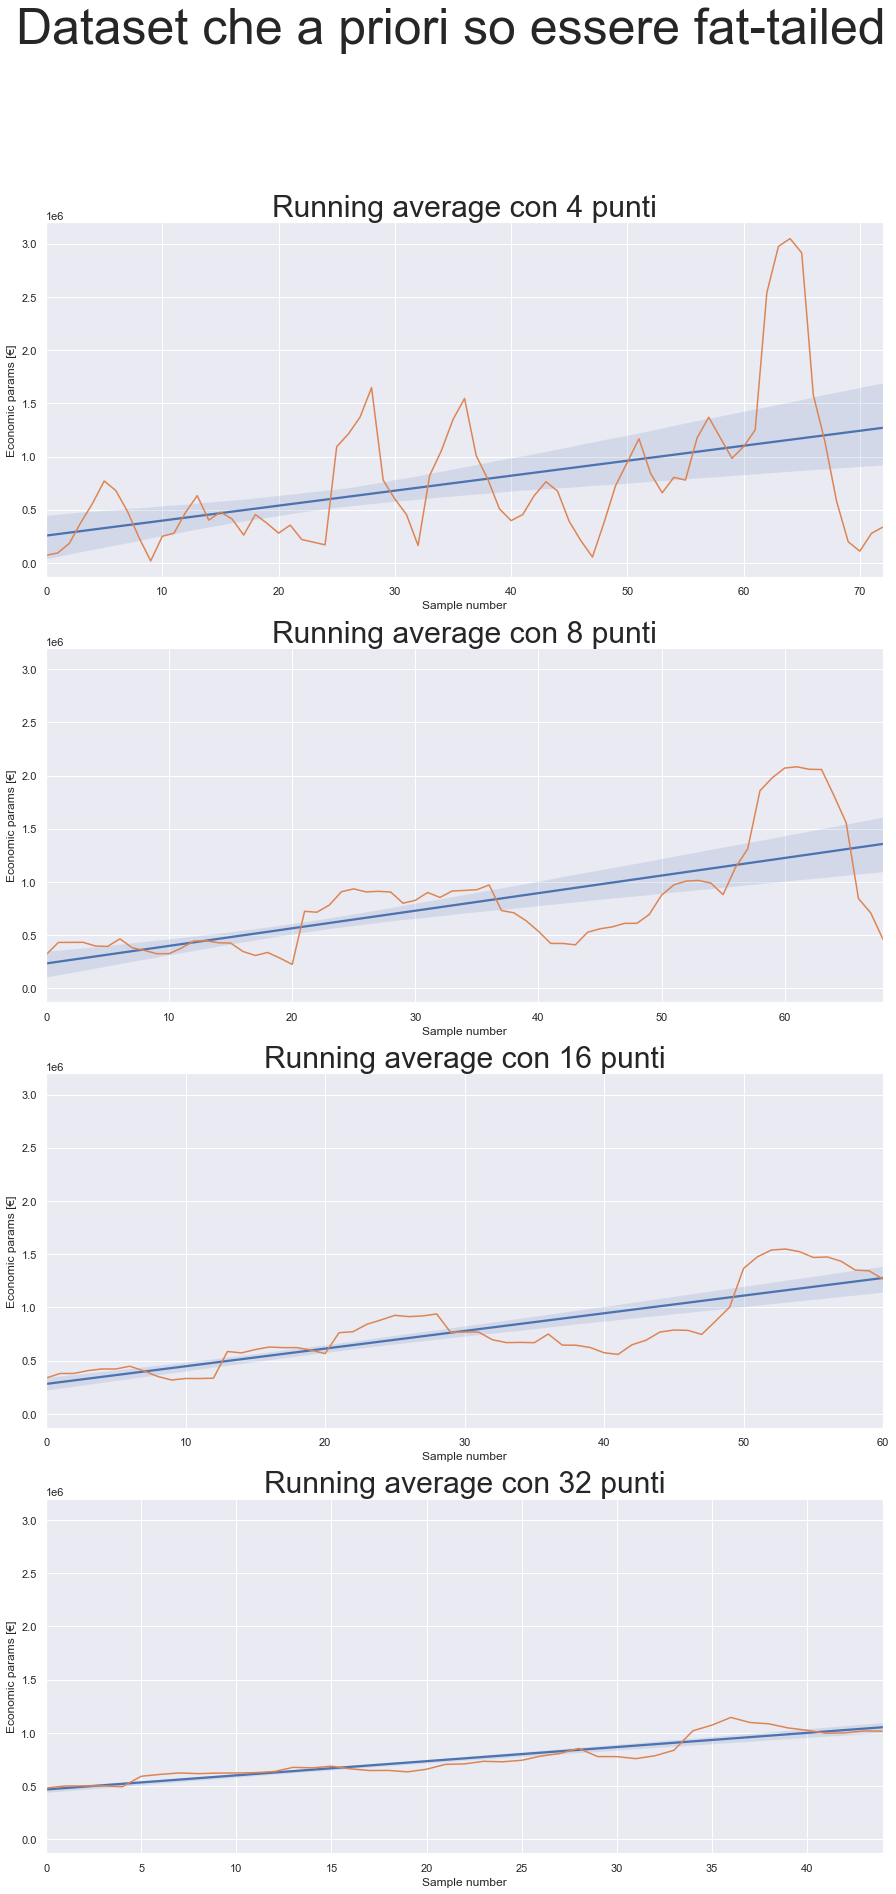

In [1]:
import copy
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

ds = pandas.read_csv("../../data/GECON dataset.csv")
copyds = copy.deepcopy(ds)


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


windows = ["4", "8", "16", "32"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset che a priori so essere fat-tailed",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(copyds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Sample number", ylabel="Economic params [€]")
    x += 1

Dai plot sopra, nonostante abbia fatto una media mobile con una lunghezza della finestra notevole rispetto al numero di
campioni, questo non è risultato sufficiente a togliere i "trend" nei dati. Questa caratteristica che abbiamo osservato
qualitativamente, è un segnale di comportamento self-similar caratteristico soprattutto nelle reti dati. 

Ripropongo la stessa visualizzazione con i dati della rete simulata. Questo mostrato è una serie di plot del segnale
quantità di pacchetti che percorrono il piano di controllo:

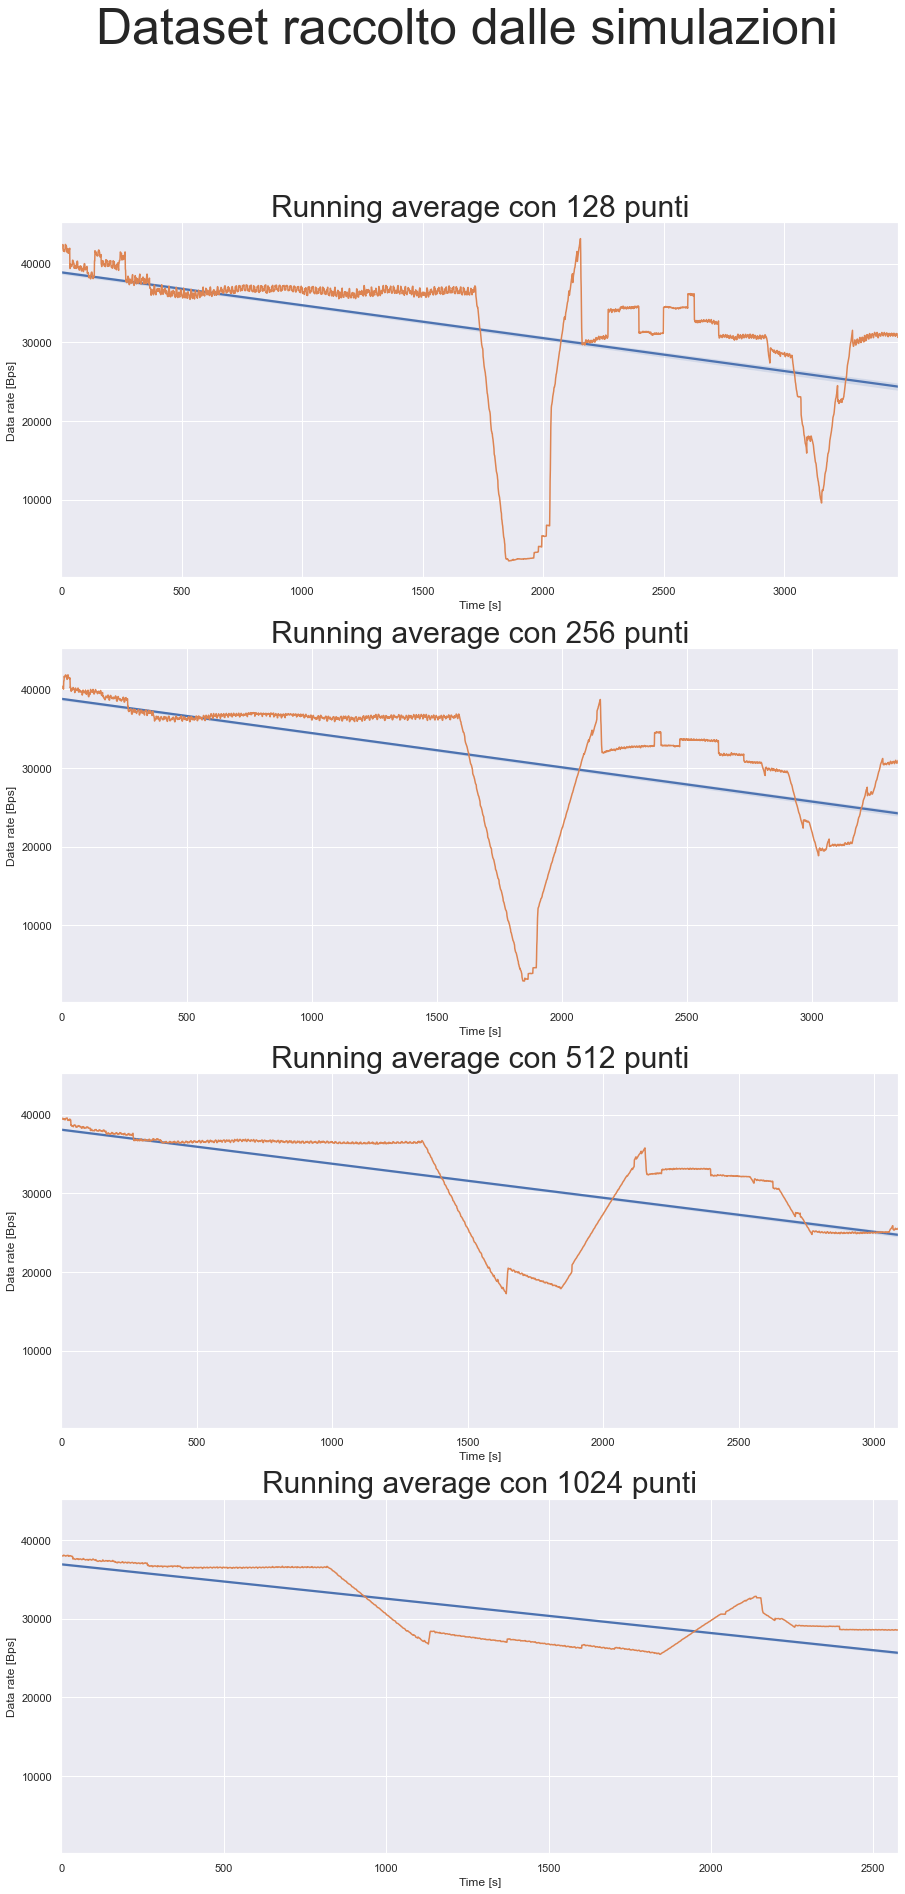

In [2]:
ds = pandas.read_csv("../../data/1 ora eserczio rete con piano lavoro REST.csv")
net_ds = copy.deepcopy(ds)
# indexNames = net_ds[net_ds['Bps'] < 1000].index
# net_ds.drop(indexNames, inplace=True)
windows = ["128", "256", "512", "1024"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset raccolto dalle simulazioni",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(net_ds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Time [s]", ylabel="Data rate [Bps]")
    x += 1

Il fatto che questi dati suggeriscano una presenza di distribuzioni di tipo fat-tailed induce a riflettere nel trarre le
conclusioni. Sappiamo che la rete dati mostra un comportamento fat-tailed, dunque al limite tenderà ad una distribuzione *stable*.
Questo che conseguenze ha nella pratica? 

Ragioniamo facendo uso di un ulteriore strumento: la teoria dei valori estremi.
Secondo questa congettura nelle distribuzioni fat-tailed si vede un'applicazione del detto:"al peggio non c'è mai fine".
Questa espressione la capiamo ragionando sui dati degli uragani negli USA, i quali sono distribuiti in modo fat-tailed. Per quanto
riguarda i dati distribuiti in modo fat-tailed e le loro proprietà applicati al dataset degli uragani, possiamo dire che
usando la distribuzione degli eventi eventi in eccesso definita come data una soglia minima $u$ ho $ P[X>x|X>u] $ possiamo dire che in tutti i dataset
si osserva che $\displaystyle E(P[X>x|X>u]) $ se fissata una soglia
$ u $ e volendo (fra tutti i valori oltre la soglia) cercare gli eventi estremi, possiamo dire che la loro media sarà
sempre e comunque maggiore della soglia. Tutto ciò applicato agli uragani ci permette di dire che fissata una soglia di
danni economici causati da questi uragani, presa una certa soglia di danni economici, la media dei danni sarà maggiore di quella soglia. Da
questo possiamo dire che guardando agli uragani **non** è possibile trovare una soglia $ u $ tale che $E(P[X>x|X>u]) \leq u $.

```{note}
Tutto ciò è vero anche se spingo sempre più la soglia dei danni, da cui il detto: al peggio non c'è mai fine.
```

Questo principio vale per tutti i dati distribuiti secondo pmf fat-tailed, dunque anche per i dati che ho raccolto nella
rete con control-plane 1-hop. Dimostro la precedente
con un precedente dataset raccolto in una rete wifi non infrastrutturata con un'applicazione di generazione dati UDP.
Dalla letteratura sappiamo che il segnale throuput nella rete è distribuito secondo una stabile. Osserviamo i seguenti dati:

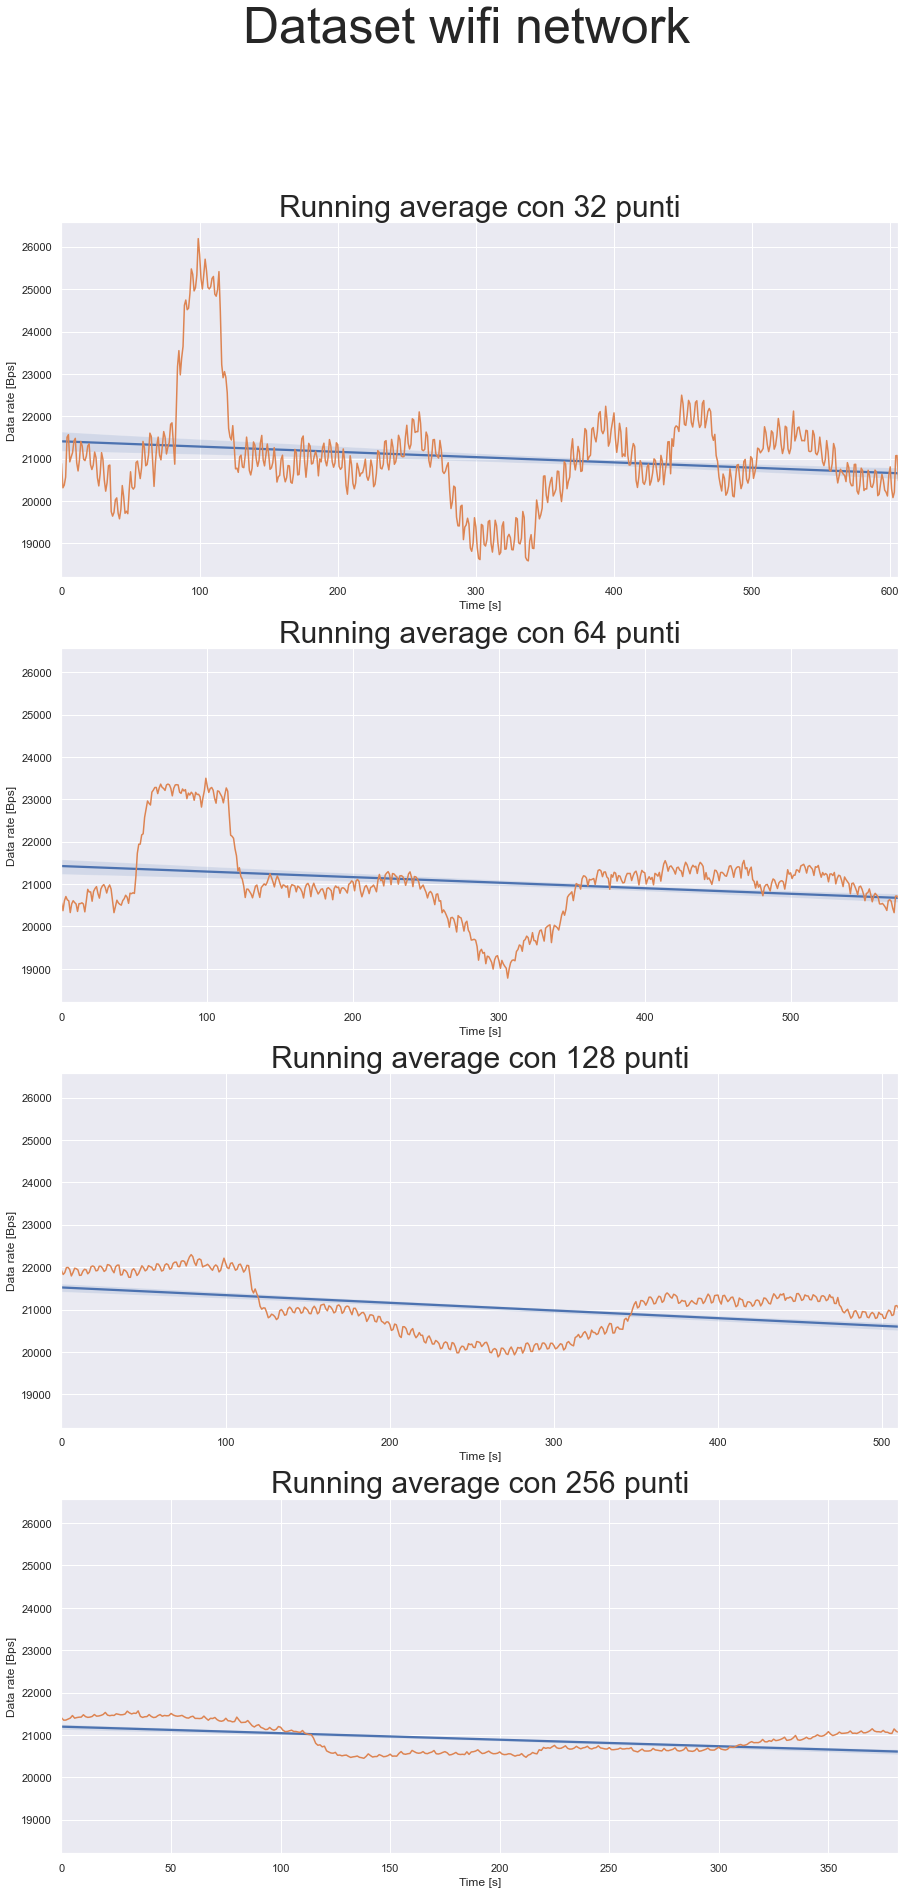

In [3]:
ds = pandas.read_csv("../../data/capture_wifi.csv")
net_ds = copy.deepcopy(ds)
# indexNames = net_ds[net_ds['Bps'] < 1000].index
# net_ds.drop(indexNames, inplace=True)
windows = ["32", "64", "128", "256"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset wifi network",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(net_ds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Time [s]", ylabel="Data rate [Bps]")
    x += 1

### Conlusioni dell'analisi empirica dei dati

La cosa principale che capiamo da questi grafici e le formule esposte è: 

    il fatto che "al peggio non ci sia mai" fine vale anche nella rete. 

Questo lo capiamo in quanto i dataset appartengono a categorie di applicazioni generiche
che sono distribuite, tutte quante, secondo distribuzioni fat-tailed. Dunque, anche per le reti vale la proprietà
riguardante la excess distribution. Dunque fissata una soglia di throughput lungo il control plane, la media dei
throughput osservati nella excess distribution, cioè tali per cui $ X>u $, sarà
sempre maggiore della soglia. Peggio ancora, più spingo la soglia dei throughput , più la media dei dati osservati
sarà in ogni caso maggiore della soglia, in teoria anche se la soglia venisse trascinata al limite. Quest'ultima cosa
avviene ad esempio nei casi di broadcast storm, in tutti gli altri casi varò una saturazione e congestione della rete.

Come dimostrazione finale mostro un fit fatto con la survivor function della distribuzione fat-tailed dei miei dati ed
una distribuzione fat-tailed del tipo Pareto generalizzata 

<img height="400" src="C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys\assets\fit.jpg" width="400"/>

## Modello della rete

Adesso analizziamo una applicazione di controllo della rete per mitigare le problematiche esposte prima con
la distribuzione dei dati.

Una prima soluzione è quella di identificare gli eventi estremi e risolvere quei casi. Ragionanando in questo modo, possiamo
pensare che l'evento catastrofico da risolvere siano i broadcast storm dovuti ai cicli nella rete.

    soluzione: eliminiamo i cicli ed usiamo STP

Questa soluzione purtroppo non tiene conto della stabilità della rete. È possibile dimostrare che una rete con UDP è modellabile,
dal punto di vista della propagazione dati, come un sistema lineare e quindi posso fare un'analisi della stabilità.
Ciò che si può dimostrare, è che una rete con UDP è un sistema stabile ma che in generale ha caratteristiche di margine di
fase molto fragili, basta poco per far saturare la rete. Per convincersene basti pensare agli attacchi "smurf", cioè
di amplificazione, principalmente utilizzano protocolli trasporto che non prevedono controlli distribuiti sul carico immesso
nella rete (ad esempio broadcast ping). Col protocollo TCP risolviamo il problema grazie ai suoi algoritmi
di gestione del flusso (sliding window). Questa però non è una soluzione definitiva in quanto anche se accoppiassi TCP con IP, 
e quindi mettessi controllo congesitone e controllo del flusso, non effettuo un'ottimizzazione congiunta ma opero su due livelli diversi. 
Il risultato è che nonstante tutte le euristiche che posso mettere in campo sarò sempre legato ad una strategia subottima.

Quest'ultima frase significa che nel piano di controllo di una rete di sensori SDN è necessario usare protocolli di
trasmissione leggeri (simil-UDP) con qualche meccanismo di controllo della congestione e di controllo del flusso, anche basilari. 
Se queste precauzioni non vengono prese e quindi si punta solo "alla leggerezza" del protocollo, ci esponiamo al rischio di overflowing dei dispositivi. 

Questo avviene, soprattutto nella simulazione, perché nel piano di controllo
ipotizzato nello strumento, ho 1 hop di propagazione. Con un modello del genere, nel caso peggiore trasmetterò un
numero $ o(n^2) $ pacchetti con $n$ il numero di nodi. Il bound quadratico nel numero dei nodi si giustifica pensando che
qualunque pacchetto da qualunque nodo verrà ritrasmesso in ogni collegamento. Il caso peggiore è che ci sia un messaggio
per ogni collegamento e per ogni nodo, cioè $ \frac{n(n-1)}{2} \sim n^2 $ in pratica la situazione di una mesh.

Nello studio dell'applicazione di controllo della rete, iniziamo studiando gli algoritmi di controllo distribuiti e la loro teoria.
Accennando la teoria degli algoritmi distribuiti usati in Internet, principalmente gli algoritmi di controllo del carico 
sulla rete sono di due tipi:
* Distribuito
* Centralizzato

Nel seguente paragrafo vediamo gli algoritmi distribuiti di controllo della rete e poi nell'ultimo paragrafo vediamo gli
algoritmi centralizzati e come li ho implementati nel controller Ryu.

Topologia: 


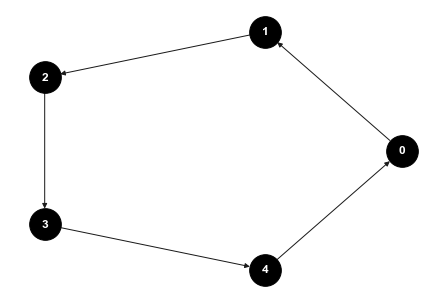

In [4]:
print("Topologia: ")
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

for i in range(0, 5):
    G.add_node(i)

pos = nx.circular_layout(G)

G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 0)

nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_size=1000, node_color='black', font_color='white')
plt.show()

Questo esempio è il modello della rete ad anello che uso per far vedere quali sono alcuni problemi che possono nascere.

Supponiamo il traffico entri nel nodo $ i $ e lasci la rete attraverso il nodo $ [(i+1) mod n] +1 $. Indicando con $ x_i $
il rate del traffico che il nodo $ i $ offre alla rete ed indicando $ x_i' $ il rate del traffico nel collegamento col
nodo successivo allora abbiamo:

\begin{equation}
    \begin{cases}
      x_i = min(x_i, \frac{c_i}{x_i+x_{i-1}'})\\
      x_i'' = min(x_i', \frac{c_{i+1}}{x_i'+x_{i+1}}x_i')
    \end{cases}\
\end{equation}

Chiamando $c_i$ la capacità del i-esimo arco, per semplicità ipotizziamo $ c_i = c $ ed $ x_i = x \quad \forall i \quad in \quad N $. 
A questo punto possiamo dire che
se <br> $ x \leq c/2 $ allora non ci saranno perdite e $ x = x' = x'' $ ed il throughput della rete sarà $ nx $. <br>
Altrimenti si può dire che:
<br>  $ x' = \frac{cx}{x+x'} $ ed ottengo $ x'=\frac{x}{2}(\sqrt{1+4\frac{c}{x}}-1) $ <br>
ed inoltre sempre dalle equazioni precedenti so che
<br> $ x'' = \frac{cx'}{x+x'} $ ed ottengo $ x''= c - \frac{x}{2}(\sqrt{1+4\frac{c}{x}} -1) $ <br>
Uso l'approssimazione di Taylor al primo ordine ed ottengo $ x'' = \frac{c^2}{x} +o(\frac{1}{x}) $ dove $ o(\frac{1}{x}) $
denota tutti i termini di ordine superiore al secondo. Dunque si vede che <br> $ \lim_{x\to\infty} x''=0 $ <br> Il rate dunque va
a zero ed anche il throughput andrà a zero, questo è il *congestion collapse*. 
    
    Ogni device dovrà limitare la quantità di traffico offerto alla rete, *ma come*?

La teoria degli algoritmi distribuiti è ancora abbastanza aperta e non abbiamo grossi strumenti pratici con cui lavorare. Il principale
algoritmo asincrono e distribuito che abbiamo a disposizione è l'algoritmo di Bellman-Ford per il  cammino minimo in un
grafo. Questo algoritmo nonostante tutte le sue belle proprietà di convergenza (addirittura anche nel caso di informazioni non aggiornate)
nella pratica ha prestazioni scarse nelle reti. Bellman-Ford è l'algoritmo al cuore di RIP, il quale è stato soppiantato 
da OSPF che usa Djikstra nel calcolo del cammino minimo. 

Il caso del calcolo del cammino minimo è solo il primo degli esempi di algoritmi che a livello teorico esistono e ne è stata
dimostrata la convergenza alla soluzione, ma nella pratica hanno una complessità implementativa troppo elevata o non è 
possibile integrarli nei sistemi odierni di telecomunicazione. Cioè so che esiste un algoritmo fantastico per ottimizzare
ma è imposssibile usarlo nella pratica, questa è una situazione frequente nelle reti di telecomunicazioni.

Dunque se non posso usare all'atto pratico molti di questi algoritmi distribuiti, per un problema teorico/di complessità o di implementazione,
cosa possiamo usare?

    Possiamo passare alle tecniche centralizzate.
    
Queste tecniche centralizzate le analizzaimo perché la stragrande maggioranza degli algoritmi di rete è il risultato di problemi di ottimizzazione.
Questi algoritmi hanno bisgno di essere eseguiti su un unica CPU, con tutte le informazioni della rete e senza bisogno
di doversi sincronizzare con altri. Questi sono algoritmi *centralizzati*. Questi algoritmi, che abbiamo definito come "centralizzati" esistono,
il problema è passare all'integrazione nella rete.

Per risolvere il problema del'integrazione nella rete di questi algoritmi centralizzati e vedere esplicata tutta la loro
funzione ho bisogno di:
* un meccanismo di raccolta e trasporto delle informazioni dai vari dispositivi al calcolatore
* un metodo risolutivo veloce abbastanza da essere utile nella pratica (non è banale)
* un meccanismo di redistribuzione dei calcoli e delle soluzioni applicate alla rete (ad ogni dispositivo)

Il controller SDN è un ottimo candidato per eseguire tutte queste funzioni con OpenFlow. Nei successivi pragrafi verrà mostrato
il risultato dell'uso di un controller in una rete WSN.

```{warning}
Nel considerare i vantaggi e svantaggi delle varie tecniche va capito cosa paghiamo per ottenere i benefici esposti. 
```
Il warning precedente sottolinea una ipotesi fondamentale alla base delle tecniche esposte qui:
    
    La soluzione proposta ha un costo

Il costo da pagare in termini di traffico di segnalazione "non pagante", è quello mostrato nei plot precedenti ed è quantificabile
in circa 3 kbps per ogni dispostivo connesso.

Con queste informazioni possiamo decidere se:
* pagare questo costo in termini di traffico di segnalazione sia sostenibile (ad esempio nelle applicazioni di WSN con bisogno di elevata affidabilità)
* oppure questo costo è insostenibile ed usiamo questo sistema semplicemente come upper bound di ottimalità nei risultati di 
    * affidabilità
    * aumento di throughput dovuto ad una allocazione efficente delle risorse 
    * un controllo della topologia